In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Algebraic Multigrid and Finite Element Methods

Factorization as a multigrid (or domain decomposition) method incurs significant cost in multiple dimensions due to lack of sparsity.  It is not feasible to choose enough coarse basis functions so that coarse basis functions that use minimum energy extensions $-F^{-1} B^T$ (see $P_c$ and the notation above) have sufficiently local support.

Algebraic multigrid methods operate by specifying a coarsening algorithm and degree of sparsity, then attempting to choose good basis functions within those constraints.  Classical AMG chooses coarse points much like the factorization methods above, but restricts the support of the basis functions and uses heuristics to weight the contributions in order to approximate selected functions (like the constant).  Smoothed aggregation chooses aggregates and *tentative* basis functions $T$ on the aggregates (to reproduce the constants or other functions exactly), then uses Jacobi relaxation to compute an interpolation $P = (I - \omega D^{-1} J)T$ which is smoother than $T$, but with correspondingly larger support.

Let's examine this construction of basis functions for the 1D Laplacian.

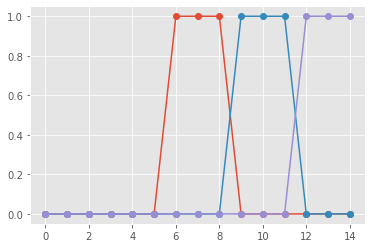

In [2]:
m = 15
cfactor = 3
agg = np.arange(m) // cfactor
mc = max(agg)+1
T = np.zeros((m,mc))
T[np.arange(m), agg] = 1

plt.plot(T[:6*cfactor,2:5], '-o');

## Generalize to multiple dimensions

In [3]:
import meshio
m = meshio.read('insulated-4.1.msh')
m

<meshio mesh object>
  Number of points: 67
  Number of elements:
    line: 21
    triangle: 111
  Cell data: gmsh:physical

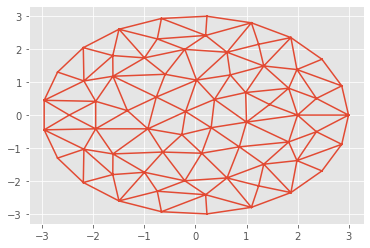

In [4]:
tris = m.cells['triangle']
vtx = m.points[:,:2]
plt.triplot(vtx[:,0], vtx[:,1], triangles=tris);

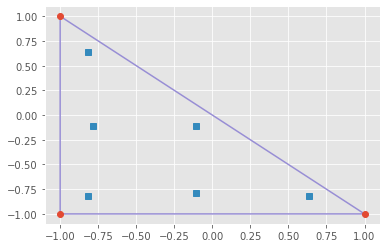

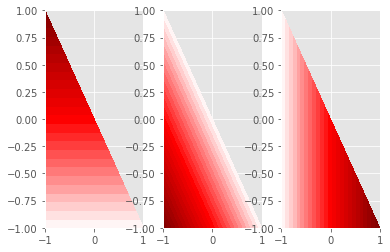

In [5]:
%run femtools.py
fe2tri(1).plot()

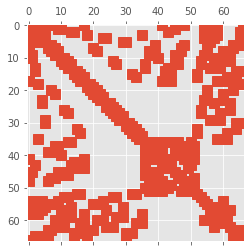

In [6]:
import scipy.sparse as sp

def poisson(vtx, tris, K=np.eye(2)):
    fe = fe2tri(1)
    B = fe.B
    D = fe.D
    w = fe.w
    ai = []
    aj = []
    aa = []
    for e in tris:
        x = vtx[e]
        dxdX = D @ x
        Jac = np.linalg.det(dxdX)
        dXdx = np.linalg.inv(dxdX)
        Ae = np.einsum('qYi,qYy,q,yx,qXx,qXj->ij', D, dXdx, w*Jac, K, dXdx, D)
        ai += np.outer(e, np.ones_like(e)).flatten().tolist()
        aj += np.outer(np.ones_like(e), e).flatten().tolist()
        aa += Ae.flatten().tolist()
    Ndof = len(vtx)
    return sp.csr_matrix((aa, (ai, aj)), shape=(Ndof,Ndof))

A = poisson(vtx, tris)
plt.spy(A);

In [7]:
print(A[10:12,:])

  (0, 1)	-1.5630160271053208
  (0, 10)	6.556997868019531
  (0, 11)	-0.4991399480099342
  (0, 40)	-1.9953216391894464
  (0, 45)	0.3840234553139328
  (0, 46)	-1.7094454886739032
  (0, 57)	-0.23058360488609603
  (0, 62)	-0.943514615468765
  (1, 10)	-0.49913994800993416
  (1, 11)	5.542813429859226
  (1, 12)	-0.10388463632263972
  (1, 26)	-2.7474164337774893
  (1, 46)	-0.8370082745892002
  (1, 53)	-0.46431808983657663
  (1, 62)	-0.8910460473233867


[ 9.4139805   9.68128117 10.27995246 10.34278686 10.93310486 11.4109622 ]


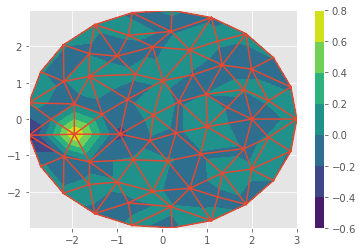

In [8]:
import scipy.sparse.linalg as spla
from matplotlib.tri import Triangulation
Tri = Triangulation(vtx[:,0], vtx[:,1], triangles=tris)

L, X = spla.eigsh(A)
print(L)
plt.triplot(Tri)
plt.tricontourf(Tri, X[:,-3])
plt.colorbar();

[-3.45938976e-16  1.85280451e-01  1.99848301e-01  4.07947457e-01
  5.22918574e-01  6.41992622e-01]


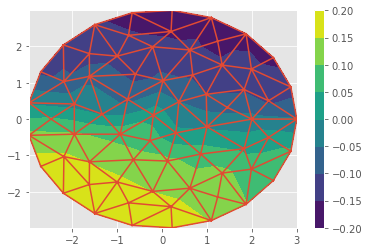

In [9]:
L, X = spla.eigsh(A, which='SM')
print(L)
plt.triplot(Tri)
plt.tricontourf(Tri, X[:,1])
plt.colorbar();

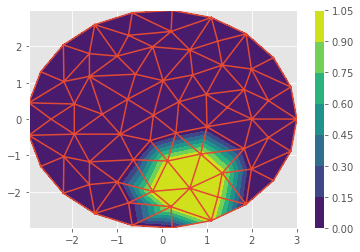

In [10]:
agg = A[15].indices
u = np.zeros_like(X[:,0])
u[agg] = 1
plt.triplot(Tri)
plt.tricontourf(Tri, u)
plt.colorbar();

In [11]:
# Note: the hiccup in class was that I still used eigvalsh() (for Hermitian/symmetric matrices)
# even though D^{-1} A is not symmetric (despite having a non-negative real spectrum).  When
# using eigvals(), we need to explicitly sort. 

sorted(np.linalg.eigvals(1/A.diagonal()[:,None] * np.array(A.todense())))[:10]

[1.8041124150158794e-16,
 0.042696928864341385,
 0.0505115882282515,
 0.11183694042048116,
 0.1387743693449715,
 0.18411024946995722,
 0.19607371754490172,
 0.25917793178986664,
 0.28728307149386784,
 0.3091821071345255]

0.0 1.0
-0.024685331055504047 1.0773930751561949


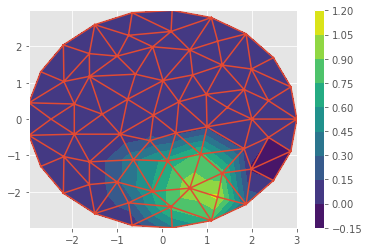

In [12]:
us = u - 0.6 / A.diagonal() * (A @ u)
print(np.min(u), np.max(u))
print(np.min(us), np.max(us))
plt.triplot(Tri)
plt.tricontourf(Tri, us)
plt.colorbar();

### Smoothed aggregation

By performing one iteration of Jacobi relaxation
$$ P = (I - w A) T $$
we create coarses basis functions that more accurately approximate the smooth functions. This is evaluated as
```python
P = A @ T
P = T - w*P # in-place
```

We can form the Galerkin coarse operator using these smoothed coarse basis functions $A_c = P^T A P$ and observe better convergence than with plain aggregation.

This is usually computed as $P^T (A P)$ or $R = P^T$ followed by $ R (A P)$, where the term in parentheses is either normalized into (parallel) compressed sparse row (CSR) format or held in a similar intermediate representation.  It is also possible to do efficiently in which only one row of $A P$ is generated at a time, and the entire product is never held in memory.  This [performs](https://gitlab.com/petsc/petsc/merge_requests/1640#note_205294524) slightly worse, but uses much less memory.

This triple product is usually the most expensive part of AMG setup.  At extreme levels of parallelism, the communication pattern for smoothing and restriction/interpolation on coarse grids can also be critical. Some packages (e.g., PETSc's GAMG) reduce the active process set while others run in-place.

* [Bell, Dalton, Olson (2012): Exposing Fine-Grained Parallelism in Algebraic Multigrid Methods](https://epubs.siam.org/doi/abs/10.1137/110838844)
* [Bienz, Gropp, Olson (2019): Reducing Communication in Algebraic Multigrid with Multi-step Node Aware Communication](https://arxiv.org/abs/1904.05838)
* [De Sterck, Yang, Heys (2006): Reducing Complexity in Parallel Algebraic Multigrid Preconditioners](https://epubs.siam.org/doi/abs/10.1137/040615729)

![](amg-fig.png)
![](amg-table.png)


## AMG on Summit

This performance exploration comes from recent runs of PETSc's GAMG with and without GPUs on OLCF Summit, compared with a 2x28-core Skylake node.

```
------------------------------------------------------------------------------------------------------------------------
Event                Count      Time (sec)     Flop                              --- Global ---  --- Stage ----  Total   GPU    - CpuToGpu -   - GpuToCpu - GPU
                   Max Ratio  Max     Ratio   Max  Ratio  Mess   AvgLen  Reduct  %T %F %M %L %R  %T %F %M %L %R Mflop/s Mflop/s Count   Size   Count   Size  %F
---------------------------------------------------------------------------------------------------------------------------------------------------------------


$ rg 'MGInterp Level 4|MGSmooth Level 4' ex56*
ex56-JLSE-skylake-56ranks-converged.txt
254:MGSmooth Level 4      68 1.0 1.8808e+00 1.2 7.93e+08 1.3 3.6e+04 1.9e+04 3.4e+01  8 29 10 16  3  62 60 18 54 25 22391
256:MGInterp Level 4      68 1.0 4.0043e-01 1.8 1.45e+08 1.3 2.2e+04 2.5e+03 0.0e+00  1  5  6  1  0   9 11 11  4  0 19109

ex56-summit-cpu-36ranks-converged.txt
265:MGSmooth Level 4      68 1.0 1.1531e+00 1.1 1.22e+09 1.2 2.3e+04 2.6e+04 3.4e+01  3 29  7 13  3  61 60 12 54 25 36519       0      0 0.00e+00    0 0.00e+00  0
267:MGInterp Level 4      68 1.0 2.0749e-01 1.1 2.23e+08 1.2 1.4e+04 3.4e+03 0.0e+00  0  5  4  1  0  11 11  7  4  0 36925       0      0 0.00e+00    0 0.00e+00  0

ex56-summit-gpu-24ranks-converged.txt
275:MGSmooth Level 4      68 1.0 1.4499e-01 1.2 1.85e+09 1.2 1.0e+04 5.3e+04 3.4e+01  0 29  7 13  3  26 60 12 55 25 299156   940881    115 2.46e+01  116 8.64e+01 100
277:MGInterp Level 4      68 1.0 1.7674e-01 1.0 3.23e+08 1.2 6.1e+03 6.7e+03 0.0e+00  0  5  4  1  0  33 11  7  4  0 42715   621223     36 2.98e+01  136 3.95e+00 100

ex56-summit-gpu-36ranks-converged.txt
275:MGSmooth Level 4      68 1.0 1.4877e-01 1.2 1.25e+09 1.2 2.3e+04 2.6e+04 3.4e+01  0 29  7 13  3  19 60 12 54 25 291548   719522    115 1.83e+01  116 5.80e+01 100
277:MGInterp Level 4      68 1.0 2.4317e-01 1.0 2.20e+08 1.2 1.4e+04 3.4e+03 0.0e+00  0  5  4  1  0  33 11  7  4  0 31062   586044     36 1.99e+01  136 2.82e+00 100
```

The Skylake is a lot faster at PtAP.  It'd be interesting to better
understand why.  Perhaps it has to do with caching or aggressiveness of
out-of-order execution.

```
$ rg 'PtAP' ex56*
ex56-JLSE-skylake-56ranks-converged.txt
164:MatPtAP                4 1.0 1.4214e+00 1.0 3.94e+08 1.5 1.1e+04 7.4e+04 4.4e+01  6 13  3 20  4   8 28  8 39  5 13754
165:MatPtAPSymbolic        4 1.0 8.3981e-01 1.0 0.00e+00 0.0 6.5e+03 7.3e+04 2.8e+01  4  0  2 12  2   5  0  5 23  3     0
166:MatPtAPNumeric         4 1.0 5.8402e-01 1.0 3.94e+08 1.5 4.5e+03 7.5e+04 1.6e+01  2 13  1  8  1   3 28  3 16  2 33474

ex56-summit-cpu-36ranks-converged.txt
164:MatPtAP                4 1.0 3.9077e+00 1.0 5.89e+08 1.4 1.6e+04 7.4e+04 4.4e+01  9 13  5 26  4  11 28 12 46  5  4991       0      0 0.00e+00    0 0.00e+00  0
165:MatPtAPSymbolic        4 1.0 1.9525e+00 1.0 0.00e+00 0.0 1.2e+04 7.3e+04 2.8e+01  5  0  4 19  3   5  0  9 34  3     0       0      0 0.00e+00    0 0.00e+00  0
166:MatPtAPNumeric         4 1.0 1.9621e+00 1.0 5.89e+08 1.4 4.0e+03 7.5e+04 1.6e+01  5 13  1  7  1   5 28  3 12  2  9940       0      0 0.00e+00    0 0.00e+00  0

ex56-summit-gpu-24ranks-converged.txt
167:MatPtAP                4 1.0 5.7210e+00 1.0 8.48e+08 1.3 7.5e+03 1.3e+05 4.4e+01  8 13  5 25  4  11 28 12 46  5  3415       0     16 3.36e+01    4 6.30e-02  0
168:MatPtAPSymbolic        4 1.0 2.8717e+00 1.0 0.00e+00 0.0 5.5e+03 1.3e+05 2.8e+01  4  0  4 19  3   5  0  9 34  3     0       0      0 0.00e+00    0 0.00e+00  0
169:MatPtAPNumeric         4 1.0 2.8537e+00 1.0 8.48e+08 1.3 2.0e+03 1.3e+05 1.6e+01  4 13  1  7  1   5 28  3 12  2  6846       0     16 3.36e+01    4 6.30e-02  0

ex56-summit-gpu-36ranks-converged.txt
167:MatPtAP                4 1.0 4.0340e+00 1.0 5.89e+08 1.4 1.6e+04 7.4e+04 4.4e+01  8 13  5 26  4  11 28 12 46  5  4835       0     16 2.30e+01    4 5.18e-02  0
168:MatPtAPSymbolic        4 1.0 2.0355e+00 1.0 0.00e+00 0.0 1.2e+04 7.3e+04 2.8e+01  4  0  4 19  3   5  0  9 34  3     0       0      0 0.00e+00    0 0.00e+00  0
169:MatPtAPNumeric         4 1.0 2.0050e+00 1.0 5.89e+08 1.4 4.0e+03 7.5e+04 1.6e+01  4 13  1  7  1   5 28  3 12  2  9728       0     16 2.30e+01    4 5.18e-02  0
```

The transpose operation is relatively more expensive with GPUs, suggesting that a better code path on GPUs is to compute an explicit transpose.

```
$ rg 'MGInterp|MultTrans' ex56*
ex56-JLSE-skylake-56ranks-converged.txt
222:MatMultTranspose     136 1.0 3.5105e-01 3.7 7.91e+07 1.3 2.5e+04 1.3e+03 0.0e+00  1  3  7  1  0   5  6 13  3  0 11755
247:MGInterp Level 1      68 1.0 3.3894e-04 2.2 2.35e+05 0.0 0.0e+00 0.0e+00 0.0e+00  0  0  0  0  0   0  0  0  0  0   693
250:MGInterp Level 2      68 1.0 1.1212e-0278.0 1.17e+06 0.0 1.8e+03 7.7e+02 0.0e+00  0  0  1  0  0   0  0  1  0  0  2172
253:MGInterp Level 3      68 1.0 6.7105e-02 5.3 1.23e+07 1.8 2.7e+04 4.2e+02 0.0e+00  0  0  8  0  0   1  1 14  1  0  8594
256:MGInterp Level 4      68 1.0 4.0043e-01 1.8 1.45e+08 1.3 2.2e+04 2.5e+03 0.0e+00  1  5  6  1  0   9 11 11  4  0 19109

ex56-summit-cpu-36ranks-converged.txt
229:MatMultTranspose     136 1.0 1.4832e-01 1.4 1.21e+08 1.2 1.9e+04 1.5e+03 0.0e+00  0  3  6  1  0   6  6 10  3  0 27842       0      0 0.00e+00    0 0.00e+00  0
258:MGInterp Level 1      68 1.0 2.9145e-04 1.5 1.08e+05 0.0 0.0e+00 0.0e+00 0.0e+00  0  0  0  0  0   0  0  0  0  0   370       0      0 0.00e+00    0 0.00e+00  0
261:MGInterp Level 2      68 1.0 5.7095e-03 1.5 9.16e+05 2.5 2.4e+03 7.1e+02 0.0e+00  0  0  1  0  0   0  0  1  0  0  4093       0      0 0.00e+00    0 0.00e+00  0
264:MGInterp Level 3      68 1.0 3.5654e-02 2.8 1.77e+07 1.5 2.3e+04 3.9e+02 0.0e+00  0  0  7  0  0   1  1 12  1  0 16095       0      0 0.00e+00    0 0.00e+00  0
267:MGInterp Level 4      68 1.0 2.0749e-01 1.1 2.23e+08 1.2 1.4e+04 3.4e+03 0.0e+00  0  5  4  1  0  11 11  7  4  0 36925       0      0 0.00e+00    0 0.00e+00  0

ex56-summit-gpu-24ranks-converged.txt
236:MatMultTranspose     136 1.0 2.1445e-01 1.0 1.72e+08 1.2 9.5e+03 2.6e+03 0.0e+00  0  3  6  1  0  39  6 11  3  0 18719   451131      8 3.11e+01  272 2.19e+00 100
268:MGInterp Level 1      68 1.0 4.0388e-03 2.8 1.08e+05 0.0 0.0e+00 0.0e+00 0.0e+00  0  0  0  0  0   0  0  0  0  0    27      79     37 5.84e-04   68 6.80e-05 100
271:MGInterp Level 2      68 1.0 2.9033e-02 2.9 1.25e+06 1.9 1.6e+03 7.8e+02 0.0e+00  0  0  1  0  0   5  0  2  0  0   812   11539     36 1.14e-01  136 5.41e-02 100
274:MGInterp Level 3      68 1.0 4.9503e-02 1.1 2.50e+07 1.4 1.1e+04 6.3e+02 0.0e+00  0  0  7  0  0   9  1 13  1  0 11476   100889     36 2.29e+00  136 3.74e-01 100
277:MGInterp Level 4      68 1.0 1.7674e-01 1.0 3.23e+08 1.2 6.1e+03 6.7e+03 0.0e+00  0  5  4  1  0  33 11  7  4  0 42715   621223     36 2.98e+01  136 3.95e+00 100

ex56-summit-gpu-36ranks-converged.txt
236:MatMultTranspose     136 1.0 2.9692e-01 1.0 1.17e+08 1.2 1.9e+04 1.5e+03 0.0e+00  1  3  6  1  0  40  6 10  3  0 13521   336701      8 2.08e+01  272 1.59e+00 100
268:MGInterp Level 1      68 1.0 3.8752e-03 2.5 1.03e+05 0.0 0.0e+00 0.0e+00 0.0e+00  0  0  0  0  0   0  0  0  0  0    27      79     37 3.95e-04   68 4.53e-05 100
271:MGInterp Level 2      68 1.0 3.5465e-02 2.2 9.12e+05 2.5 2.4e+03 7.1e+02 0.0e+00  0  0  1  0  0   4  0  1  0  0   655    5989     36 8.16e-02  136 4.89e-02 100
274:MGInterp Level 3      68 1.0 6.7101e-02 1.1 1.75e+07 1.5 2.3e+04 3.9e+02 0.0e+00  0  0  7  0  0   9  1 12  1  0  8455   56175     36 1.55e+00  136 3.03e-01 100
277:MGInterp Level 4      68 1.0 2.4317e-01 1.0 2.20e+08 1.2 1.4e+04 3.4e+03 0.0e+00  0  5  4  1  0  33 11  7  4  0 31062   586044     36 1.99e+01  136 2.82e+00 100
```